In [11]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import caffe
import itertools as it
import pandas as pd
import cv2
import scipy
import seaborn
import lmdb
import shutil
import json

from caffe.proto import caffe_pb2
from collections import defaultdict, Counter
from math import ceil
from copy import copy
from collections import OrderedDict
from operator import itemgetter, attrgetter
from matplotlib import pyplot
from scipy import ndimage as ndimage
from os.path import join as pjoin
from ete3 import Tree, TreeStyle, faces, AttrFace

from caffe import layers as L
from caffe import params as P
import tools

from ntb.layer.data import Transformer
from ntb.db import *

from training.util import *
from training.labels import *

%matplotlib inline
pyplot.rcParams['figure.figsize'] = (10, 6)

In [2]:
db = NTBDB()

In [3]:
def plot_distribution(data):
    pic_num_distribution = {
        label: len(imgs) for label, imgs in data.items()
    }
    data = sorted(pic_num_distribution.items(), key=itemgetter(1), reverse=True)
    df = pd.DataFrame.from_dict(OrderedDict(data), orient='index')
    df.plot(kind='bar', legend=False)

def make_datum(img, label, img_width=227, img_height=227):
    return caffe_pb2.Datum(
        channels=3,
        width=img_width,
        height=img_height,
        label=label,
        data=np.rollaxis(img, 2).tostring()
    )

def transform_img(img, img_width=227, img_height=227, equalize_hist=False):
    if equalize_hist:
        img[:, :, 0] = cv2.equalizeHist(img[:, :, 0])
        img[:, :, 1] = cv2.equalizeHist(img[:, :, 1])
        img[:, :, 2] = cv2.equalizeHist(img[:, :, 2])

    img = cv2.resize(img, (img_width, img_height), interpolation = cv2.INTER_CUBIC)
    return img

def write_lmdb(lmdb_path, indexes, batch_size=2000):
    indexes = np.asarray(list(indexes))
    np.random.shuffle(indexes)
    batch_num = int(ceil(indexes.size/float(batch_size)))
    print "Writing {} images ({} batches) to {}".format(len(indexes), batch_num, lmdb_path)
    with lmdb.open(lmdb_path, map_size=227*227*3*2*indexes.size, writemap=True) as in_db:
        index_lmdb = 0
        for batch_idx, batch in enumerate(np.array_split(indexes, batch_num)):
            with in_db.begin(write=True) as in_txn:
                for index in batch:
                    img = cv2.imread(db.image_path(index), cv2.IMREAD_COLOR)
                    img = transform_img(img)
                    for label in labels:
                        if index in dataset[label]:
                            break
                    else:
                        raise ValueError("no label: " + index)
                    label_id = np.where(labels == label)[0][0]
                    datum = make_datum(img, label_id)
                    try:
                        in_txn.put('{:0>5d}'.format(index_lmdb), datum.SerializeToString())
                    except Exception as e:
                        print 'ERROR', index, str(e)
                        raise
                    index_lmdb += 1
                print "batch", batch_idx, "finished"

def show_tag_tree(tree, dst='%%inline'):
    def my_layout(node):
        if node.name:
            faces.add_face_to_node(AttrFace("name"), node, column=0, position="branch-right")
    ts = TreeStyle()
    ts.show_leaf_name = False
    ts.layout_fn = my_layout
    return tree.render(dst, tree_style=ts)

def tag_score(tag_name):
    origin_tags = db.tags.search_nodes(name=tag_name)
    tags = set(origin_tags)
    for tag in origin_tags:
        tags.update(tag.get_descendants())
    return len({im['filename'] for tag in tags for im in db.by_tag.get(tag.name, [])})

def show_tag_tree_with_scores(tree, dst='%%inline'):
    def my_layout(node):
        if node.name:
#             node.name = node.name + '(' + str(len(db.by_tag_with_children(node.name))) + ')'
            faces.add_face_to_node(AttrFace("name"), node, column=0, position="branch-right")
            scores_txt = "({}) {}".format(len({i['filename'] for i in db.by_tag.get(node.name, [])}), tag_score(node.name))
            faces.add_face_to_node(faces.TextFace(scores_txt), node, column=1, position="branch-right")
    ts = TreeStyle()
    ts.show_leaf_name = False
    ts.layout_fn = my_layout
    return tree.render(dst, tree_style=ts)

In [4]:
def split_dataset_simple(dataset, ratio):
    imgs = set(it.chain.from_iterable(dataset.itervalues()))
    imgs1 = set(random.sample(imgs, int(ceil(len(imgs) * ratio))))
    imgs2 = imgs - imgs1
    split1 = {}
    split2 = {}
    for label, imgs in dataset.iteritems():
        split1[label] = imgs.intersection(imgs1)
        split2[label] = imgs.intersection(imgs2)
    return split1, split2

In [5]:
def threshold_dataset(dataset, threshold):
    return {label: imgs for label, imgs in dataset.iteritems() if len(imgs) >= threshold}

def train_val_test_split(dataset, method='simple'):
    if method == 'simple':
        split_dataset = split_dataset_simple
    test, rest = split_dataset(dataset, 0.2)
    val, train = split_dataset(rest, 0.25)
    
    # validation
    assert not set(it.chain.from_iterable(train.values())).intersection(set(it.chain.from_iterable(test.values())))
    assert not set(it.chain.from_iterable(train.values())).intersection(set(it.chain.from_iterable(val.values())))
    assert not set(it.chain.from_iterable(val.values())).intersection(set(it.chain.from_iterable(test.values())))
    missing_train = {label for label, imgs in train.iteritems() if not imgs}
    missing_val = {label for label, imgs in val.iteritems() if not imgs}
    missing_test = {label for label, imgs in test.iteritems() if not imgs}
    assert not missing_train, 'Train missing: ' + str(len(missing_train))
    assert not missing_val, 'Val missing: ' + str(len(missing_val))
    assert not missing_test, 'Test missing: ' + str(len(missing_test))
    
    return train, val, test

In [6]:
def analyse_dataset(dataset):
    print 'Total number of images:', len(set(it.chain.from_iterable(dataset.itervalues())))
    print "Total number of categories:", len(dataset)
    print "Count > 0:", len({label for label, imgs in dataset.items() if len(imgs) > 0})
    print "Count > 10:", len({label for label, imgs in dataset.items() if len(imgs) > 10})
    print "Count > 50:", len({label for label, imgs in dataset.items() if len(imgs) > 50})
    print "Count > 100:", len({label for label, imgs in dataset.items() if len(imgs) > 100})
    print "Count > 1000:", len({label for label, imgs in dataset.items() if len(imgs) > 1000})
    
    df = pd.DataFrame([len({label for label, imgs in dataset.items() if len(imgs) >= i}) for i in range(1000)], columns=['count'])
    df.plot(title='Number of images above threshold')
    
    count_df = pd.DataFrame(((label, len(imgs)) for label, imgs in dataset.iteritems()), columns=['label', 'count']).set_index('label')
    count_df.sort_values('count', ascending=False).head(30).plot(kind='bar', title='Top categories')
    
    labels_per_pic = defaultdict(int)
    for label, imgs in dataset.iteritems():
        for img in imgs:
            labels_per_pic[img] += 1
    labels_per_pic = dict(labels_per_pic)
    df = pd.DataFrame.from_dict(Counter(labels_per_pic.itervalues()), orient='index')
    plot = df.plot(kind='bar', legend=False)
    plot.set_ylabel('Count')
    plot.set_xlabel('Labels per picture')

In [18]:
def dump_raw_datasets(train, val, test, name):
    assert set(train) == set(val) == set(test), 'Labels are incorrect'
    labels = np.asarray(sorted(train.keys()))
    dataset_dir = pjoin(DATASETS_DIR, name)
    if not os.path.isdir(dataset_dir):
        os.makedirs(dataset_dir)
    with open(pjoin(dataset_dir, 'train_raw.pickle'), mode='w') as f:
        pickle.dump(train50, f, protocol=pickle.HIGHEST_PROTOCOL)
    with open(pjoin(dataset_dir, 'val_raw.pickle'), mode='w') as f:
        pickle.dump(val, f, protocol=pickle.HIGHEST_PROTOCOL)
    with open(pjoin(dataset_dir, 'test_raw.pickle'), mode='w') as f:
        pickle.dump(test, f, protocol=pickle.HIGHEST_PROTOCOL)
    with open(pjoin(dataset_dir, 'labels.np'), mode='w') as f:
        labels.dump(f)

# Skiing

In [6]:
skiing_labels = np.asarray(sorted([
    node.name 
    for node in db.tags.search_nodes(name='skiing')[0].get_descendants()
    if not node.children and len(db.by_tag[node.name]) > 1000
]))
skiing_dataset = {
    label: {
        im['filename'] for im in db.by_tag[label]
    }  for label in skiing_labels 
}

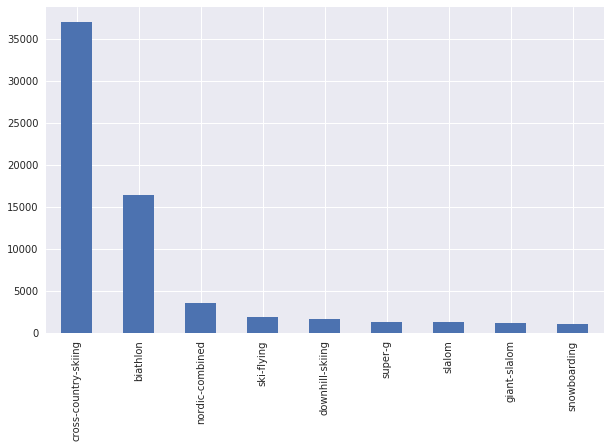

In [8]:
plot_distribution(skiing_dataset)

In [9]:
skiing_dataset_balanced = balance_dataset(skiing_dataset, limit=10000)

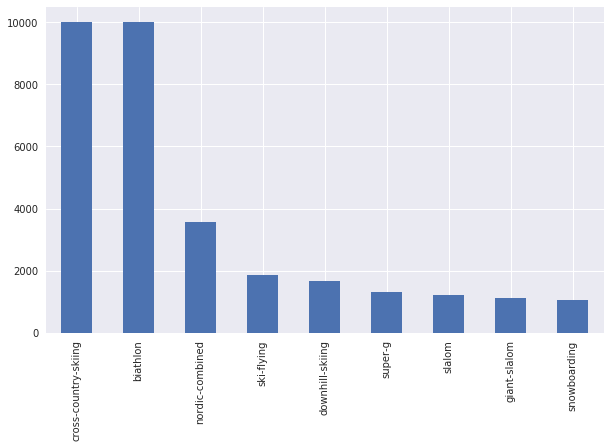

In [10]:
plot_distribution(skiing_dataset_balanced)

# Main dataset

Check for typos in categories

In [8]:
all_ntb_labels = set(t.name for t in db.tags.get_descendants())
from_merge = set([])
from_merge.update(*filter(None, SUBCLASS_MERGE.values()))
missing_labels = LABELS - all_ntb_labels.union(set(SUBCLASS_MERGE))
missing_labels_from_merge = from_merge - all_ntb_labels
missing_labels_from_merge_none = {label for label, sub_labels in SUBCLASS_MERGE.items() if sub_labels is None and not db.tags.search_nodes(name=label)}
assert not missing_labels, missing_labels
assert not missing_labels_from_merge, missing_labels_from_merge
assert not missing_labels_from_merge_none, missing_labels_from_merge_none

Create dataset of images

In [9]:
dataset = {}
for label in LABELS:
    if label in SUBCLASS_MERGE:
        sub_labels = SUBCLASS_MERGE[label]
        if sub_labels is None:
            sub_labels = {label}
            tags = db.tags.search_nodes(name=label)
            sub_labels.update(t.name for tag in tags for t in tag.get_descendants())
        dataset[label] = set(map(itemgetter('filename'), it.chain.from_iterable(db.by_tag.get(sub_label, []) for sub_label in sub_labels)))
    else:
        dataset[label] = set(i['filename'] for i in db.by_tag.get(label, []))

Total number of images: 698208
Total number of categories: 1507
Count > 0: 1358
Count > 10: 1041
Count > 50: 660
Count > 100: 523
Count > 1000: 147


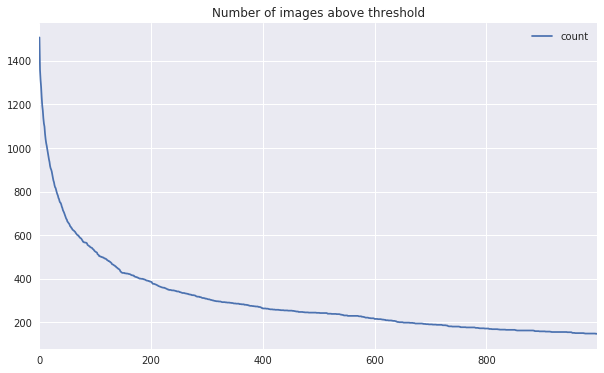

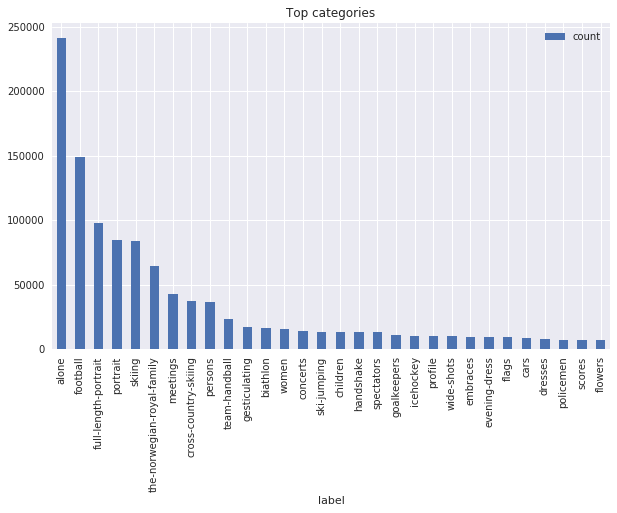

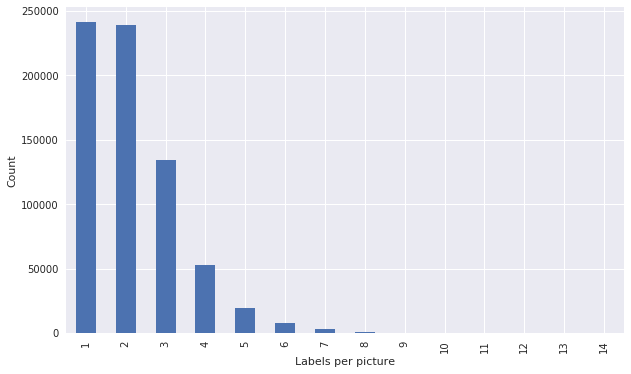

In [12]:
analyse_dataset(dataset)

### Threshold dataset at 50 images per category

In [13]:
dataset50 = threshold_dataset(dataset, 50)

Total number of images: 695718
Total number of categories: 663
Count > 0: 663
Count > 10: 663
Count > 50: 660
Count > 100: 523
Count > 1000: 147


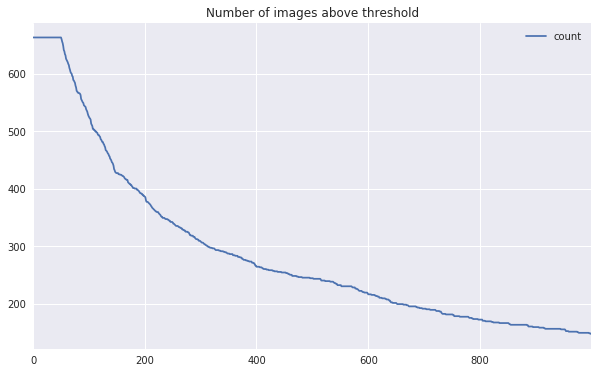

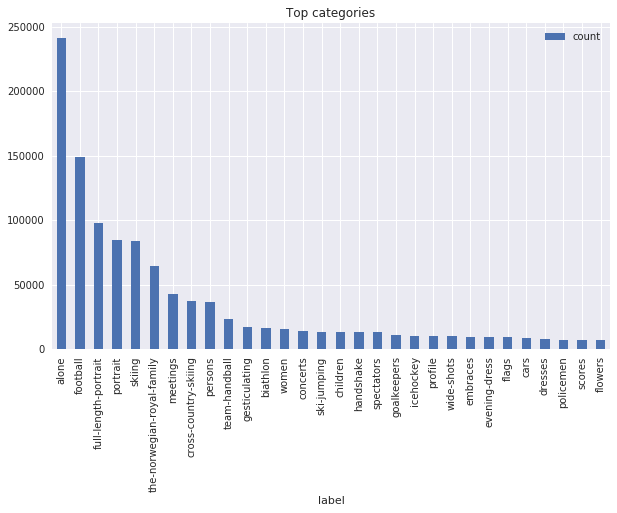

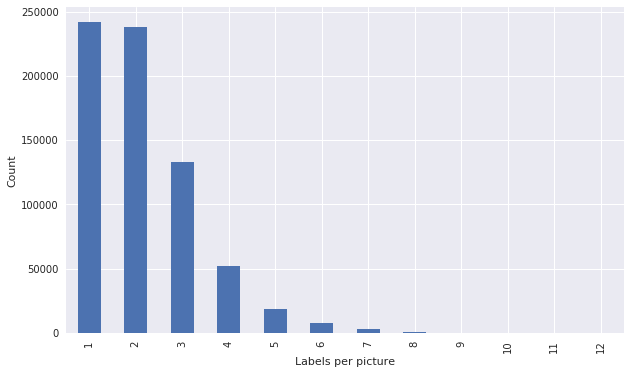

In [14]:
analyse_dataset(dataset50)

In [15]:
train50, val50, test50 = train_val_test_split(dataset50)

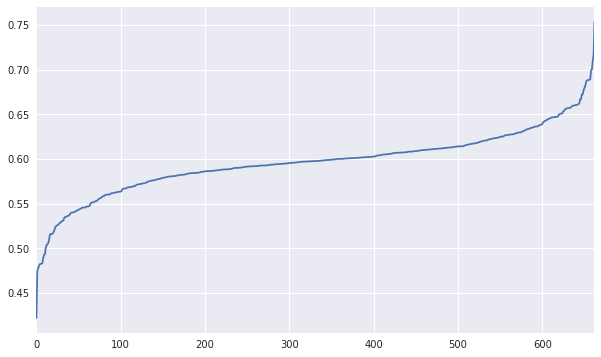

In [16]:
pd.Series(sorted(float(len(imgs))/len(dataset[label]) for label, imgs in train50.iteritems())).plot()

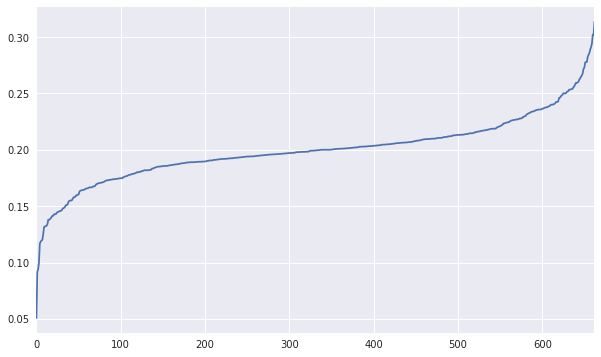

In [137]:
pd.Series(sorted(float(len(imgs))/len(dataset[label]) for label, imgs in test50.iteritems())).plot()

Dump datasets

In [20]:
dump_raw_datasets(train=train50, val=val50, test=test50, name='raw_50')

In [ ]:
# def dump_lmdb_datasets(train, val, name):
#     assert set(train) == set(val) == set(test), 'Labels are incorrect'
#     labels = np.asarray(sorted(train.keys()))
#     dataset_dir = pjoin(DATASETS_DIR, name)
#     if not os.path.isdir(dataset_dir):
#         os.makedirs(dataset_dir)
#     train_lmdb = pjoin(dataset_dir, 'train.lmdb')
#     val_lmdb = pjoin(dataset_dir, 'val.lmdb')
#     mean_image = pjoin(dataset_dir, 'mean_image.binaryproto')
    